In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import matplotlib
from numpy import inf

matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

# 1. 데이터 로드
- 유동인구 : flow
- 카드 : card
- 유통 : gs
- 물류 : cj

In [2]:
# load data
flow_201902 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201902.csv", sep='|')
flow_201903 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201903.csv", sep='|')
flow_201904 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201904.csv", sep='|')
flow_201905 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_201905.csv", sep='|')
flow_202002 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202002.csv", sep='|')
flow_202003 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202003.csv", sep='|')
flow_202004 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202004.csv", sep='|')
flow_202005 = pd.read_csv("../data/original_data/raw_data/01_유동인구데이터(SK텔레콤)/4개지역_FLOW_AGE_202005.csv", sep='|')
flow = pd.concat([flow_201902, flow_201903, flow_201904, flow_201905, flow_202002, flow_202003, flow_202004, flow_202005], axis=0)

# melt
flow = pd.melt( flow, 
                id_vars=['STD_YM', 'STD_YMD', 'HDONG_CD', 'HDONG_NM'], 
                value_vars=flow.columns[4:].tolist())
flow.rename(columns={"value":"FLOW"}, inplace=True)

# 성별 추출 + 연령 추출
sex_dict = {"MAN":"M", "WMAN":"F"}
flow['SEX_CD'] = flow['variable'].apply(lambda x:sex_dict[x.split('_')[0]])
flow['AGE_CD'] = flow['variable'].apply(lambda x:x.split('_')[-1][:4])

# 날짜처리
weekdays = {0:'월', 1:'화', 2:'수', 3:'목', 4:'금', 5:'토', 6:'일'}
flow['STD_YMD'] = pd.to_datetime(flow.STD_YMD, format='%Y%m%d')
#flow['YEAR'] = flow.STD_YMD.dt.year
#flow['MONTH'] = flow.STD_YMD.dt.month
#flow['WEEK_NUM'] = flow.STD_YMD.dt.weekofyear
#flow['WEEKDAY'] = flow.STD_YMD.dt.dayofweek.apply(lambda x : '_'.join([str(x),weekdays.get(x)]))

# 재정렬
#flow = flow[['STD_YMD', 'STD_YM', 'YEAR', 'MONTH', 'WEEK_NUM', 'WEEKDAY', 'HDONG_NM', 'SEX_CD', 'AGE_CD', 'FLOW']]

In [3]:
card = pd.read_csv("../data/original_data/processed_data/CARD_SPENDING_RESIDENT_KOR.csv")
card['STD_DD'] = pd.to_datetime(card['STD_DD'], format="%Y%m%d")

cj = pd.read_excel("../data/original_data/raw_data/05_물류데이터(CJ올리브네트웍스)/2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx")
cj['HDNG_NM'] = cj['HDNG_NM'].replace("신당제5동", "신당5동")
cj['DL_YMD'] = pd.to_datetime(cj['DL_YMD'], format="%y%m%d")

In [4]:
dong_to_si = {}
dong_to_gu = {}

for si, dong in cj[['CTPV_NM', 'HDNG_NM']].values:
    if dong not in dong_to_si:
        dong_to_si[dong] = si

for gu, dong in cj[['CTGG_NM', 'HDNG_NM']].values:
    if dong not in dong_to_gu:
        dong_to_gu[dong] = gu

In [5]:
flow['SI'] = flow['HDONG_NM'].apply(lambda x:dong_to_si[x])
flow['GU'] = flow['HDONG_NM'].apply(lambda x:dong_to_gu[x])
flow = flow[['STD_YMD', "SI", "GU", "HDONG_NM", 'SEX_CD', 'AGE_CD', 'FLOW']]
flow.rename(columns={"STD_YMD":"YMD", "HDONG_NM":"DONG", "SEX_CD":"SEX", "AGE_CD":"AGE"}, inplace=True)

In [6]:
card['SI'] = card['DONG_CD'].apply(lambda x:dong_to_si[x])
card['GU'] = card['DONG_CD'].apply(lambda x:dong_to_gu[x])
card = card[['STD_DD', "SI", "GU", 'DONG_CD', 'MCT_CAT_CD', 'SEX_CD', 'AGE_CD', 'USE_CNT', 'USE_AMT']]
card.rename(columns={"STD_DD":"YMD", "DONG_CD":"DONG", "MCT_CAT_CD":"CAT", "SEX_CD":"SEX", "AGE_CD":"AGE"}, inplace=True)

In [7]:
cj['SI'] = cj['HDNG_NM'].apply(lambda x:dong_to_si[x])
cj['GU'] = cj['HDNG_NM'].apply(lambda x:dong_to_gu[x])
cj = cj[['DL_YMD', 'SI', 'GU', 'HDNG_NM', 'DL_GD_LCLS_NM', 'INVC_CONT']]
cj.rename(columns={"DL_YMD":"YMD", "HDNG_NM":"DONG", 'DL_GD_LCLS_NM':"CAT"}, inplace=True)

In [8]:
display(flow.head(3))
display(card.head(3))
display(cj.head(3))

,YMD,SI,GU,DONG,SEX,AGE,FLOW
0,2019-02-01,서울특별시,중구,소공동,M,0004,16.64
1,2019-02-02,서울특별시,중구,소공동,M,0004,3.14
2,2019-02-03,서울특별시,중구,소공동,M,0004,1.38


,YMD,SI,GU,DONG,CAT,SEX,AGE,USE_CNT,USE_AMT
0,2019-02-01,대구광역시,중구,동인동,숙박,F,25,11,595
1,2019-02-01,대구광역시,중구,동인동,숙박,F,50,5,243
2,2019-02-01,대구광역시,중구,동인동,숙박,F,55,5,27


,YMD,SI,GU,DONG,CAT,INVC_CONT
0,2019-02-01,서울특별시,중구,동화동,도서/음반,16
1,2019-02-01,서울특별시,중구,신당동,가구/인테리어,4
2,2019-02-01,대구광역시,중구,성내1동,가구/인테리어,1


# 2. 유동인구와 소비횟수의 상관관계 

In [9]:
flow_sum = flow.groupby(['YMD', 'SI', 'GU', 'DONG'])[['FLOW']].sum().reset_index()

In [10]:
card_sum = card.groupby(['YMD', 'SI', 'GU', 'DONG', 'CAT'])[['USE_CNT', 'USE_AMT']].sum().reset_index()

In [11]:
cj_sum = cj

In [12]:
flow_sum_2019 = flow_sum.query('YMD < "2020-01-01"')
flow_sum_2020 = flow_sum.query('YMD >= "2020-01-01"')

card_sum_2019 = card_sum.query('YMD < "2020-01-01"')
card_sum_2020 = card_sum.query('YMD >= "2020-01-01"')

cj_sum_2019 = cj_sum.query('YMD < "2020-01-01"')
cj_sum_2020 = cj_sum.query('YMD >= "2020-01-01"')

In [13]:
def calculate_corr(card_data, flow_data):
    card_flow_corr = {}
    dongs = card_data['DONG'].unique()
    for dong in dongs:
        temp = pd.pivot_table(card_data.query(f"DONG=='{dong}'"), values='USE_CNT', index='YMD', columns='CAT', fill_value=0)
        temp = pd.merge(temp, flow_data.query(f"DONG=='{dong}'"), left_on=temp.index, right_on='YMD')
        corr = temp.drop(['YMD', 'SI', 'GU', 'DONG'], axis=1).corr()['FLOW']
        cat = corr.index
        for i, cat_value in enumerate(cat):
            if cat_value not in card_flow_corr:
                card_flow_corr[cat_value] = {}
            card_flow_corr[cat_value][dong] = corr[i]
    return card_flow_corr

In [14]:
def graph_boxplot(card_flow_corr, ncols=4, title=""):
    corr_mean = {}
    num_cat = len(card_flow_corr)
    nrows = num_cat//ncols if num_cat % ncols==0 else num_cat//ncols+1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5*(nrows)))
    for i, key in enumerate(card_flow_corr.keys()):
        row = i // ncols
        col = i % ncols
        sns.boxplot(list(card_flow_corr[key].values()), ax=axes[row][col])
        axes[row][col].set_title(key+"업종의 "+title)
        corr_mean[key] = np.median(list(card_flow_corr[key].values()))
    corr_mean_df = pd.DataFrame(list(corr_mean.values()), list(corr_mean.keys()), 
                          columns=['corr']).sort_values(by='corr', ascending=False)
    return corr_mean_df

In [15]:
card_flow_corr_2019 = calculate_corr(card_sum_2019, flow_sum_2019)
card_flow_corr_2020 = calculate_corr(card_sum_2020, flow_sum_2020)

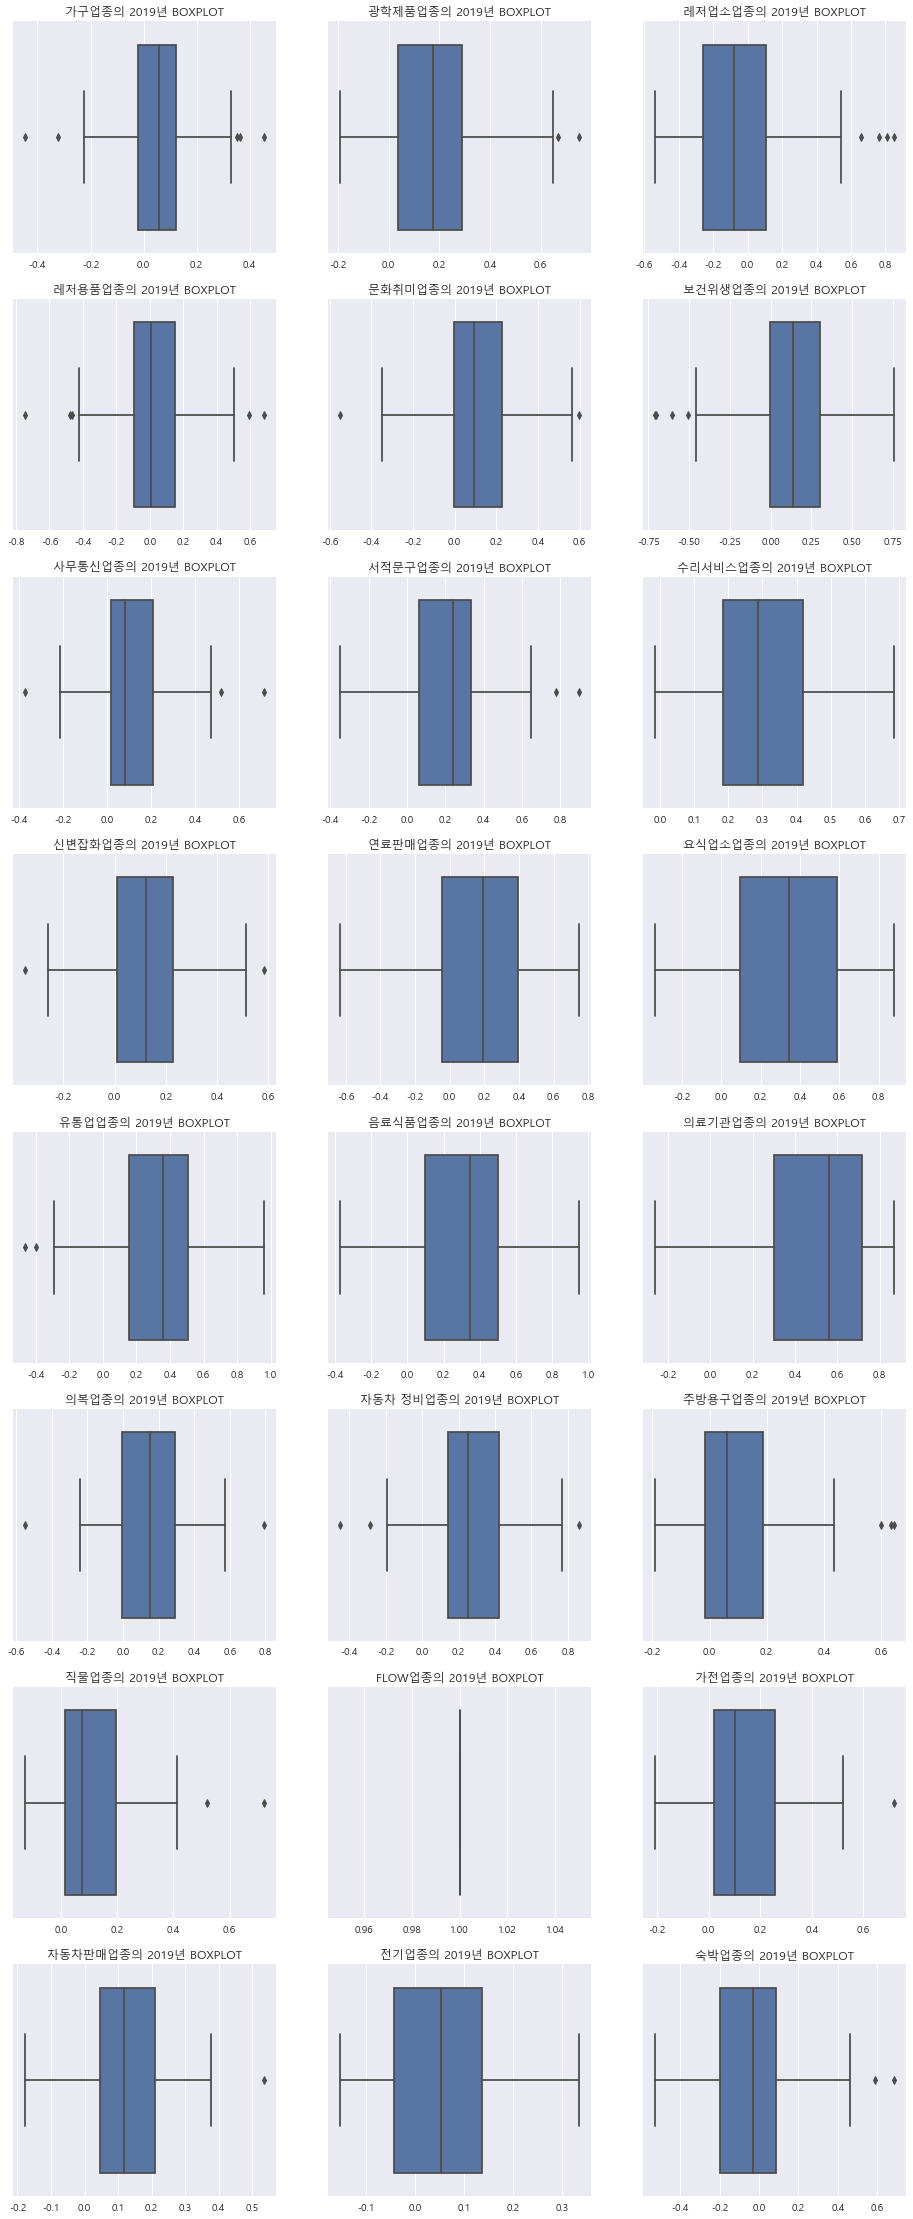

In [16]:
# 2019년 카드 소비횟수와 유동인구 사이 상관관계
corr_mean_2019 = graph_boxplot(card_flow_corr_2019, 3, "2019년 BOXPLOT")

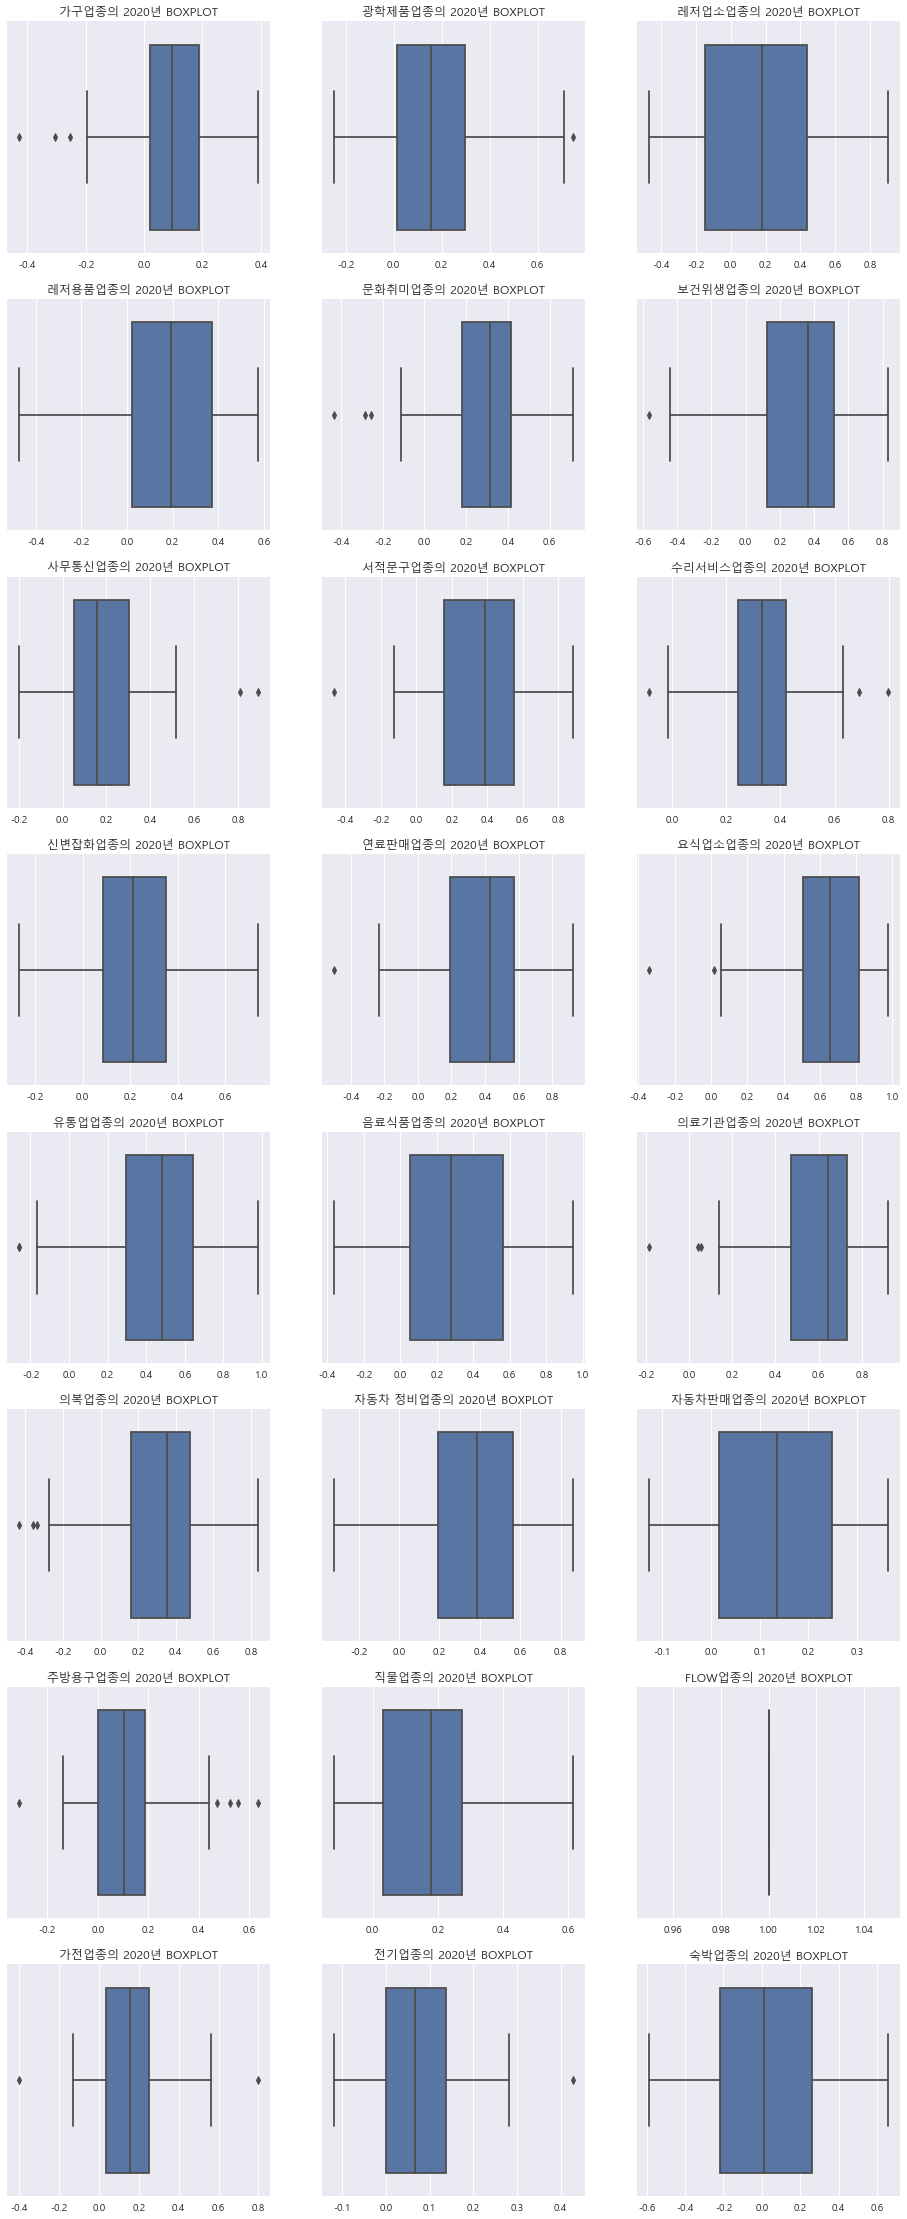

In [17]:
# 2020년 카드 소비횟수와 유동인구 사이 상관관계
corr_mean_2020 = graph_boxplot(card_flow_corr_2020, 3, "2020년 BOXPLOT")

**2019년 대비 2020년에 유동인구와 구매횟수 간 선형성이 짙어졌다**

In [18]:
print(np.round(np.mean(corr_mean_2019['corr']), 4))
print(np.round(np.mean(corr_mean_2020['corr']), 4))

0.1956
0.3025


**2019년 업종별 상관계수 중위수 VS 2020년 업종별 상관계수 중위수**
- 동별로 상관계수 구하고 중위수 취하여 그 업종의 상관계수로 채택하였다.

In [19]:
# 업종별 유동인구와 소비횟수 간 상관관계
pd.merge(corr_mean_2019, corr_mean_2020, left_on=corr_mean_2019.index, right_on=corr_mean_2020.index).sort_values(by='corr_y', ascending=False)

,key_0,corr_x,corr_y
0,FLOW,1.000000,1.000000
4,요식업소,0.342795,0.658682
1,의료기관,0.560353,0.642606
2,유통업,0.359403,0.479504
8,연료판매,0.192467,0.426295
7,서적문구,0.238738,0.387817
6,자동차 정비,0.253664,0.384881
11,보건위생,0.138423,0.367175
10,의복,0.152251,0.353660
5,수리서비스,0.285372,0.330829


## 2020년 상관계수가 더 커졌다 -> 코로나의 영향력?
- 기간별 상관계수 한 번 보자

In [20]:
def period_split(x):
    if x.month==2 and x.day<=19:
        # 2월 19일 이전
        return 'A'
    elif (x.month==2 and x.day>19) or (x.month==3 and x.day<=21):
        # 2월 20일 ~ 3월 21일
        return 'B'
    elif (x.month==3 and x.day>=22) or (x.month==4) or (x.month==5 and x.day<=5):
        # 3월 22일 ~ 5월 5일
        return 'C'
    elif (x.month==5 and x.day>=6):
        # 5월 6일~
        return 'D'

In [21]:
for dataframe in [flow_sum_2019, flow_sum_2020, card_sum_2019, card_sum_2020, cj_sum_2019, cj_sum_2020]:
    dataframe['PERIOD'] = dataframe['YMD'].map(period_split)

In [22]:
def calculate_corr_plus_period(card_data, flow_data):
    card_flow_corr = {}
    dongs = card_data['DONG'].unique()
    for period in ['A', 'B', 'C', 'D']:
        # 코로나 기간
        card_period = card_data.query(f'PERIOD=="{period}"')
        flow_period = flow_data.query(f'PERIOD=="{period}"')
        card_flow_corr[period] = {}
        for dong in dongs:
            # 동 추출 -> 카드 소비 횟수와 유동인구 사이 상관계수 구하기
            temp = pd.pivot_table(card_period.query(f"DONG=='{dong}'"), values='USE_CNT', index='YMD', columns='CAT', fill_value=0)
            temp = pd.merge(temp, flow_period.query(f"DONG=='{dong}'"), left_on=temp.index, right_on='YMD')
            corr = temp.drop(['YMD', 'SI', 'GU', 'DONG'], axis=1).corr()['FLOW']
            cat = corr.index
            for i, cat_value in enumerate(cat):
                if cat_value not in card_flow_corr[period]:
                    card_flow_corr[period][cat_value] = {}
                card_flow_corr[period][cat_value][dong] = corr[i]
    return card_flow_corr

In [23]:
def median_corr(card_flow_corr_dict, year):
    median_corr = []
    for period in ['A', 'B', 'C', 'D']:
        cat_list = []
        corr_list = []
        for cat in card_flow_corr_dict[period].keys():
            corr = np.median(list(card_flow_corr_dict[period][cat].values()))
            cat_list.append(cat)
            corr_list.append(corr)
        median_corr.append( pd.Series(index=cat_list, data=corr_list, name=year+"_"+period) )
    return pd.DataFrame([median_corr[0], median_corr[1], median_corr[2], median_corr[3]]).T

In [24]:
card_flow_corr_P_2019 = calculate_corr_plus_period(card_sum_2019, flow_sum_2019)
card_flow_corr_P_2020 = calculate_corr_plus_period(card_sum_2020, flow_sum_2020)

In [25]:
cf_corr_2019 = median_corr(card_flow_corr_P_2019, "2019")
cf_corr_2020 = median_corr(card_flow_corr_P_2020, "2020")

In [26]:
cf_corr = pd.merge(cf_corr_2019, cf_corr_2020, left_on=cf_corr_2019.index, right_on=cf_corr_2020.index).set_index('key_0')

In [27]:
cf_corr['A'] = cf_corr['2020_A']/cf_corr['2019_A']
cf_corr['B'] = cf_corr['2020_B']/cf_corr['2019_B']
cf_corr['C'] = cf_corr['2020_C']/cf_corr['2019_C']
cf_corr['D'] = cf_corr['2020_D']/cf_corr['2019_D']

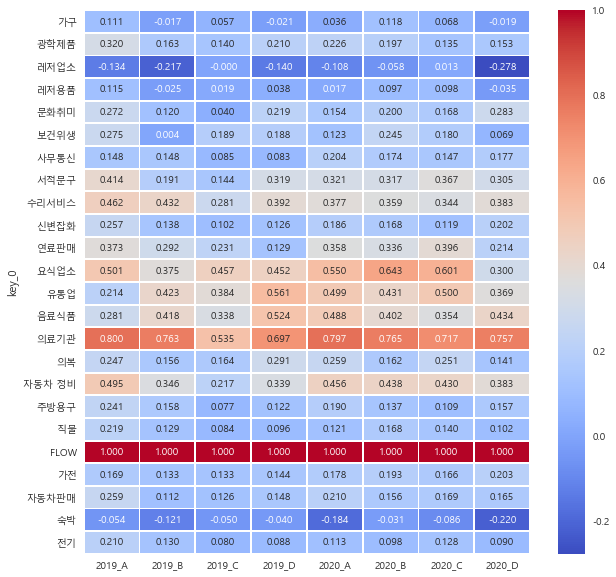

In [29]:
# 대부분의 업종에서 2019년 대비 2020년에 유동인구와 소비횟수 간 상관관계 커졌다.
# 특히 코로나가 극심했던 B기간에 유동인구와 소비횟수 간 상관관계가 높게 나타났다.
plt.figure(figsize=(10, 10))
sns.heatmap(cf_corr.drop(['A', 'B', 'C', 'D'], axis=1), fmt='.3f', annot=True, linewidths=1, cmap='coolwarm')

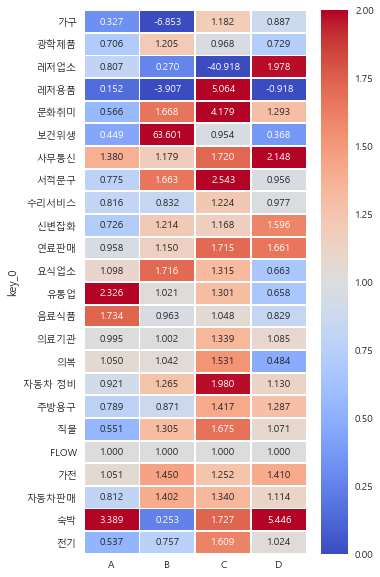

In [30]:
# 기간 별 2019년 대비 2020년 유동인구와 소비횟수 간 상관계수
# 대부분의 업종에서 2019년 대비 2020년에 유동인구와 소비횟수 간 상관관계 커졌다.
plt.figure(figsize=(5, 10))
sns.heatmap(cf_corr[['A', 'B', 'C', 'D']], fmt='.3f', annot=True, linewidths=1, cmap='coolwarm', vmin=0, vmax=2)

# 3. 업종별 전년 대비 소비수준 시각화
- 업종별 타격정도/회복정도 다르다 (기간별) BOXPLOT
- 업종별로 기간별 타격 수준이 다르다는 것을 확인하였다.
- 따라서 코로나의 타격을 많이 받은 업종과 그렇지 않은 업종,
- 이후에 이전 소비수준으로의 회복이 이루어진 업종과 그렇지 않은 업종 등으로 분류할 수 있을 것으로 예상된다.

In [32]:
card_sum = card.groupby(['YMD', 'CAT'])[['USE_CNT', 'USE_AMT']].sum().reset_index()
card_sum['PERIOD'] = card_sum['YMD'].map(period_split)
card_sum['weekofyear'] = card_sum.YMD.dt.weekofyear
card_sum['dayofweek'] = card_sum.YMD.dt.dayofweek

card_sum_2019 = card_sum.loc[card_sum['YMD']<"2020-01-01", :]
card_sum_2020 = card_sum.loc[card_sum['YMD']>="2020-01-01", :]

In [33]:
merge = pd.merge(card_sum_2019, card_sum_2020, on=['CAT', 'weekofyear', 'dayofweek', 'PERIOD'], 
                 suffixes=('_2019', '_2020'), how='inner')

In [34]:
merge['CNT_RATIO'] = merge['USE_CNT_2020'] / merge['USE_CNT_2019']
merge['AMT_RATIO'] = merge['USE_AMT_2020'] / merge['USE_AMT_2019']

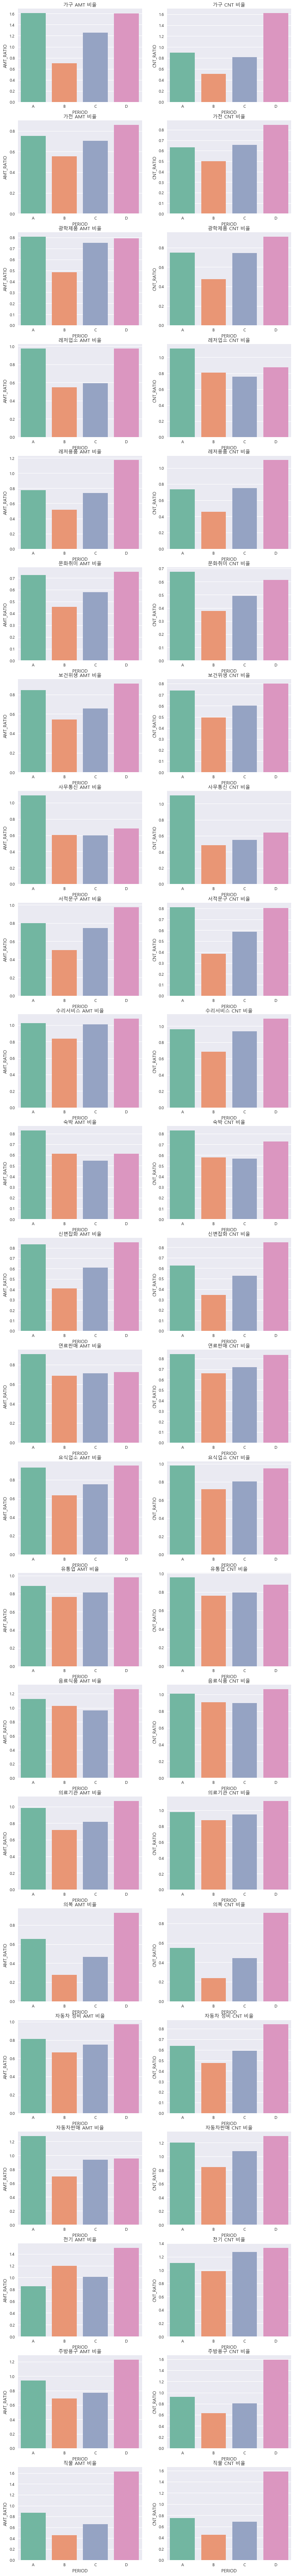

In [36]:
CATs = card_sum.CAT.unique()
fig, axes = plt.subplots(ncols=2, nrows=len(CATs), figsize=(12, 5*len(CATs)))

for i, cat in enumerate(CATs):
    temp = merge.query(f'CAT=="{cat}"')
    temp = temp.groupby(['PERIOD'])[['CNT_RATIO', 'AMT_RATIO']].median().reset_index()
    sns.barplot(x='PERIOD', y='AMT_RATIO', data=temp, ax=axes[i][0], palette='Set2')
    sns.barplot(x='PERIOD', y='CNT_RATIO', data=temp, ax=axes[i][1], palette='Set2')
    axes[i][0].set_title(cat + " AMT 비율")
    axes[i][1].set_title(cat + " CNT 비율")

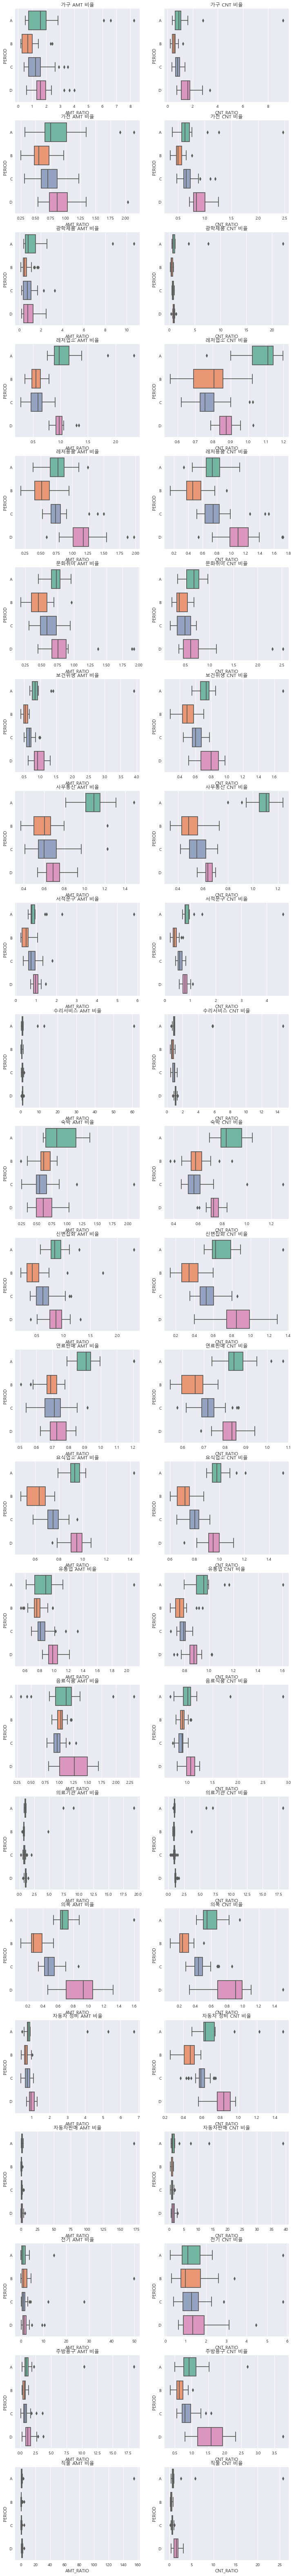

In [37]:
CATs = card_sum.CAT.unique()
fig, axes = plt.subplots(ncols=2, nrows=len(CATs), figsize=(12, 5*len(CATs)))

for i, cat in enumerate(CATs):
    temp = merge.query(f'CAT=="{cat}"')
    temp = temp.query("PERIOD in ['A', 'B', 'C', 'D']")
    sns.boxplot(x='AMT_RATIO', y='PERIOD', data=temp, ax=axes[i][0], palette='Set2')
    sns.boxplot(x='CNT_RATIO', y='PERIOD', data=temp, ax=axes[i][1], palette='Set2')
    axes[i][0].set_title(cat + " AMT 비율")
    axes[i][1].set_title(cat + " CNT 비율")

# 4. 업종 내 타격정도 차이
- 하나의 업종에 대해 연령, 성별, 지역별 타격정도 

In [38]:
card['PERIOD'] = card['YMD'].map(period_split)
card['dayofweek'] = card.YMD.dt.dayofweek
card['weekofyear'] = card.YMD.dt.weekofyear

In [39]:
card_temp = card.query("PERIOD in ['A', 'B', 'C', 'D']")

In [40]:
def agg_graph(agg_column):
    df = []
    CATs = card_temp['CAT'].unique()
    for groupcol in ['DONG', 'SEX', 'AGE']:
        card_sum = card_temp.groupby(['YMD', 'PERIOD', 'dayofweek', 'weekofyear', 'CAT', groupcol])[[agg_column]].sum().reset_index()
        card_sum_2019 = card_sum.query('YMD<"2020-01-01"')
        card_sum_2020 = card_sum.query('YMD>="2020-01-01"')
        groupby_df = pd.merge(card_sum_2019, card_sum_2020, on=['CAT', 'PERIOD', 'dayofweek', 'weekofyear', groupcol], 
                            how='inner', suffixes=['_2019', '_2020'])
        groupby_df[f'{agg_column}_RATIO'] = groupby_df[agg_column+'_2020'] / groupby_df[agg_column+'_2019']
        df.append(groupby_df)
        
    fig, axes = plt.subplots(nrows=len(CATs), ncols=3, figsize=(6*3, 6*len(CATs)))
    for i, cat in enumerate(CATs):
        groupby_DONG = df[0].query(f'CAT=="{cat}"')
        groupby_SEX = df[1].query(f'CAT=="{cat}"')
        groupby_AGE = df[2].query(f'CAT=="{cat}"')

        groupby_DONG = groupby_DONG.groupby(['DONG', 'PERIOD'])[[f'{agg_column}_RATIO']].median().reset_index()
        groupby_SEX = groupby_SEX.groupby(['SEX', 'PERIOD'])[[f'{agg_column}_RATIO']].median().reset_index()
        groupby_AGE = groupby_AGE.groupby(['AGE', 'PERIOD'])[[f'{agg_column}_RATIO']].median().reset_index()

        sns.boxplot(x=f'{agg_column}_RATIO', y='PERIOD', data=groupby_DONG, ax=axes[i][0])
        sns.barplot(x='PERIOD', y=f'{agg_column}_RATIO', hue='SEX', data=groupby_SEX, ax=axes[i][1])
        sns.barplot(x='PERIOD', y=f'{agg_column}_RATIO', hue='AGE', data=groupby_AGE, ax=axes[i][2])
        axes[i][0].set_title(f"{cat} 업종 동별 작년 대비 올해 {agg_column} 비율 분포")
        axes[i][1].set_title(f"{cat} 업종 성별 작년 대비 올해 {agg_column} 비율 분포")
        axes[i][2].set_title(f"{cat} 업종 연령별 작년 대비 올해 {agg_column} 비율 분포")
    return df

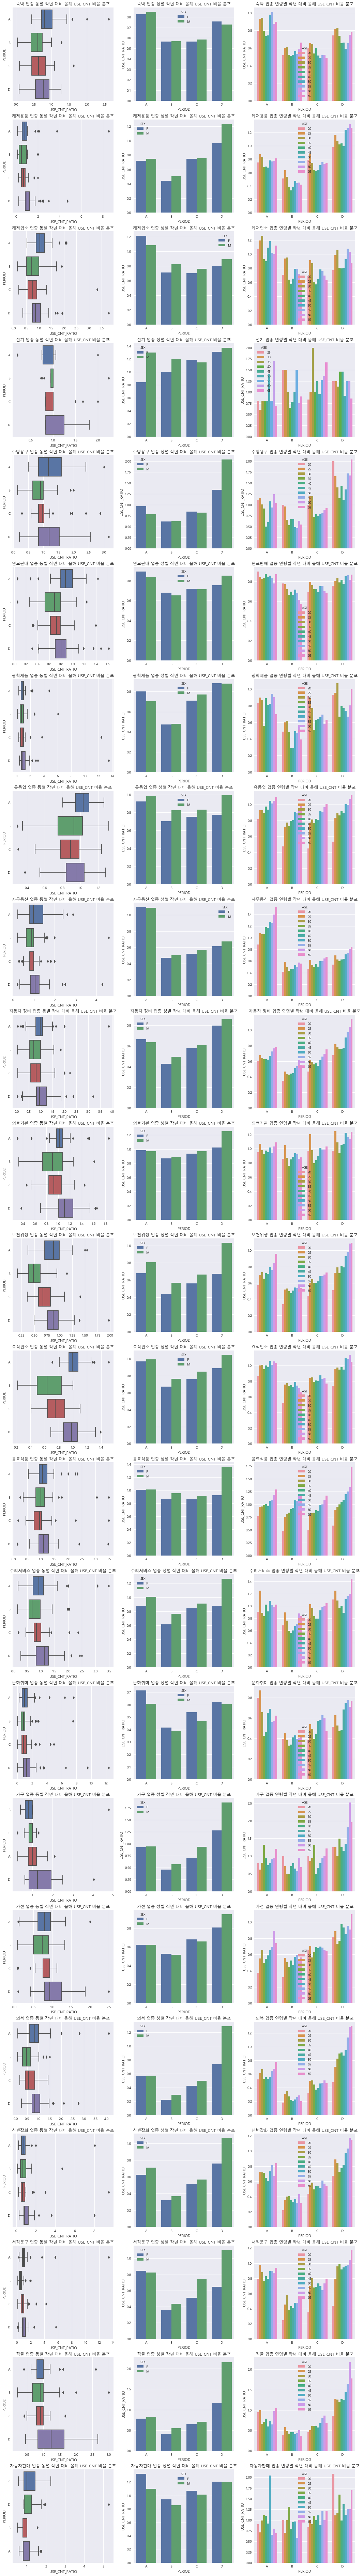

In [41]:
# 지역별, 성별, 연령별 타격정도를 상세히 알아보기 위해 시각화를 하였다.
df = agg_graph('USE_CNT')